In [2]:
import itertools
import numpy as np
import pandas as pd
from time import process_time
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# importing the tensorflow.keras libraries and packages
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import load_model
from keras.layers import concatenate
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

# importing the sklearn libraries and packages
import sklearn
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, accuracy_score

In [3]:
# load dataset
data_path = "../Dataset/MQTTset/MQTTset_total.csv"

df_MQTTset = pd.read_csv(data_path)  # read the raw training dataset into data-frame

In [4]:
X, y = df_MQTTset.iloc[:, :-1], df_MQTTset.iloc[:, -1]  # split feature, target arrays

# split dataset: training set-80% testing set-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2022)

In [5]:
# Standardisation
SCALE_IN = StandardScaler()
SCALE_IN.fit(X_train)
X_train = SCALE_IN.transform(X_train)
X_test = SCALE_IN.transform(X_test)

In [ ]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

# Y_train = np_utils.to_categorical(y_train)
# Y_test = np_utils.to_categorical(y_test)

# input_shape=(X_train.shape[1], X_train.shape[2])
# num_classes = len(y.value_counts())

In [6]:
features_num = X_test.shape[1]  # the number of features
class_num = len(np.unique(y_train))  # the number of categories

# One-hot encoding conversion for labels
Y_train = np_utils.to_categorical(y_train, class_num)
Y_test = np_utils.to_categorical(y_test, class_num)

# reshape for CNN
X_train_CNN = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
X_test_CNN = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1], 1))

# reshape for LSTM
X_train_LSTM = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_LSTM = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
model_2 = Sequential()

model_2.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(Conv1D(128, 3,  activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 256, return_sequences=True))  
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 32))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(units = 128, activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(Dense(units = num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

In [ ]:
factor = 0.01
rate = 0.2

model_3 = Sequential()

model_3.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(Conv1D(128, 3, activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 256, return_sequences=True))  
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 32))
model_3.add(Dropout(rate))

model_3.add(Flatten())

model_3.add(Dense(units = 128, activation='relu'))
model_3.add(Dropout(rate))

model_3.add(Dense(units = num_classes))
model_3.add(Activation('softmax'))

model_3.summary()

In [ ]:
model_3.compile(
    optimizer = keras.optimizers.Adam(lr=1e-4),
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
batch_size = 128
epochs = 10

In [ ]:
history_3 = model_3.fit(
    X_train, 
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

In [ ]:
score_3 = model_3.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

In [ ]:
# history_2 = model_2.fit(
#     X_train, 
#     Y_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     verbose=1,
#     validation_data=(X_test, Y_test),
#     callbacks=[
#         keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=20,
#             restore_best_weights=True
#         )
#     ]
# )

In [7]:
# CNN
CNN_model = Sequential()
CNN_model.add(Conv2D(512, kernel_size=(3, 3), activation='tanh', padding='same', input_shape=(1, features_num, 1)))  # 2D 卷积层
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # 池化层

CNN_model.add(Conv2D(256, (3, 3), activation='tanh', padding='same'))  # 2D 卷积层
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # 池化层

CNN_model.add(Conv2D(128, (3, 3), activation='tanh', padding='same'))  # 2D 卷积层
CNN_model.add(Conv2D(128, (3, 3), activation='tanh', padding='same'))  # 2D 卷积层
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # 池化层

CNN_model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))  # 2D 卷积层
CNN_model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))  # 2D 卷积层
CNN_model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))  # 2D 卷积层
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # 池化层

CNN_model.add(Flatten())


# LSTM
LSTM_model = Sequential() #  climate-based model
LSTM_model.add(LSTM(units=512, return_sequences = True, input_shape = (features_num, 1), activation='tanh'))
LSTM_model.add(LSTM(units=256, return_sequences = True))
LSTM_model.add(Dense(128, activation='relu'))
LSTM_model.add(Dense(64, activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(32, activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Flatten())

In [8]:
# concat CNN and LSTM to be a model
output = concatenate([CNN_model.output, LSTM_model.output], axis=-1)
output_model = (Dense(class_num, activation='softmax'))(output) 
model_combine = Model(inputs=[CNN_model.input, LSTM_model.input], outputs=output_model)

# plot_model(model_combine, to_file='../images/mutiModel_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
model_combine.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])  

# training log - epoch, accuracy, loss, val_accuracy, val_loss
csv_logger = CSVLogger('../Logs/MQTTset Dataset/CNN_LSTM_Muti_train.log', separator=',', append=False)

# save and load the completed training model
checkpoint  = ModelCheckpoint('../Models/MQTTset Dataset/CNN_LSTM_Muti' + '.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# reduce learning rates when evaluation indicators are not being raised
keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# Early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='auto')

In [11]:
# training CNN_LSTM model
CNN_LSTM_history = model_combine.fit([X_train_CNN, X_train_LSTM], Y_train, 
                                     batch_size=256, epochs=10,
                                     validation_data=([X_test_CNN, X_test_LSTM] , Y_test), 
                                     callbacks=[reduce_lr, es, checkpoint, csv_logger])

Epoch 1/10
1035/1035 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.8308
Epoch 1: val_loss improved from inf to 0.61281, saving model to ../Models/MQTTset Dataset\CNN_LSTM_Muti.h5
1035/1035 [==============================] - 47s 39ms/step - loss: 0.3947 - accuracy: 0.8308 - val_loss: 0.6128 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 2/10
1033/1035 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8643
Epoch 2: val_loss did not improve from 0.61281
1035/1035 [==============================] - 39s 37ms/step - loss: 0.3187 - accuracy: 0.8643 - val_loss: 1.4242 - val_accuracy: 0.6590 - lr: 0.0010
Epoch 3/10
1033/1035 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8759
Epoch 3: val_loss did not improve from 0.61281
1035/1035 [==============================] - 38s 37ms/step - loss: 0.3027 - accuracy: 0.8759 - val_loss: 1.3950 - val_accuracy: 0.7573 - lr: 0.0010
Epoch 4/10
1033/1035 [============================>.] - ETA: 

In [12]:
def plot_acc_loss(model_history):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(acc))
    
    # plot training accuracy
    plt.plot(epochs, acc, 'r', label='train_acc')
    plt.plot(epochs, val_acc, 'b', label='Validation_acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    
    # plot training loss
    plt.plot(epochs, loss, 'r', label='training_loss')
    plt.plot(epochs, val_loss, 'b', label='Validation_loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    print(np.max(model_history.history['accuracy']))
    print(np.max(model_history.history['val_accuracy']))
    

def plot_confusion_matrix(y_test, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    cm = confusion_matrix(y_test, y_pred)  # calculate confusion matrix
    # print(cm)
    
    # plot the heat map for confusion matrix 
    plt.figure()
    plt.figure(figsize=(12, 12))  #s set plot size
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return cm


def models_evaluate(model, class_num, X_test_CNN, X_train_CNN, X_test_LSTM,  X_train_LSTM, Y_test):
    """
    """
    # using modle to predict results
    predict_prob = model.predict([X_test_CNN, X_test_LSTM])

    #  returns the maximum value for every row
    y_pred = np.argmax(predict_prob, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    # calculate Confusion Matrix and plot heatmap
    confusion_matrix = plot_confusion_matrix(y_true, y_pred, classes=list(range(class_num)), title='Confusion Matrix')
    acc_score = accuracy_score(y_test, y_pred)
    
    print('-----------------------------------------------------------------------------------------------------')
    print('Testing accuracy: {:1.5f}' .format(acc_score))
    print('-----------------------------------------------------------------------------------------------------')
    print(classification_report(y_test, y_pred, digits=5))
    print('-----------------------------------------------------------------------------------------------------')

    # calculation of assessment benchmark indicators
    FP = confusion_matrix.sum(axis = 0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis = 1) - np.diag(confusion_matrix )
    TP = np.diag(confusion_matrix )
    TN = confusion_matrix.sum() - (FP + FN + TP)
    
    # calculation of other performance parameters
    accuracy = (TP + TN) / (TP + FP + FN + TN)  # accuracy of each class
    precision = TP / (TP + FP)  # Precision/ positive predictive value
    recall = TP / (TP + FN)  # Recall value
    f1_score = 2 * (recall * precision) / (recall + precision)  # F1-score
    TNR = TN / (TN + FP) # Specificity/ true negative rate
    FPR = FP / (FP + TN) # Fall out/ false positive rate
    NPV = TN / (TN + FN) # Negative predictive value
    # FNR = FN / (FN + TP) # False negative rate
    # FDR = FP / (FP + TP) # False discovery rate
    auc_val = roc_auc_score(y_true = y_pred, y_score = Y_test, multi_class='ovo')  # area under the curve
    # iou = jaccard_score(y_true, y_pred, average='micro')  # Intersection over Union
    
    # print the above benchmark indicators
    print('-----------------------------------------------------------------------------------------------------')
    df_eva = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1_Score', 'TNR', 'FPR', 'NPV'])
    df_eva['Accuracy'] = accuracy
    df_eva['Precision'] = precision
    df_eva['Recall'] = recall
    df_eva['F1_Score'] = f1_score
    df_eva['TNR'] = TNR
    df_eva['FPR'] = FPR
    df_eva['NPV'] = NPV
    # df_eva['FNR'] = FNR
    # df_eva['FDR'] = FDR
    print(df_eva)
    print('-----------------------------------------------------------------------------------------------------')

    # model_combine evaluation
    loss_train, acc_train= model_combine.evaluate([X_train_CNN, X_train_LSTM], Y_train)
    test_eval = model_combine.evaluate([X_test_CNN, X_test_LSTM], Y_test)

    print('-----------------------------------------------------------------------------------------------------')
    print('Training loss: {:1.5f}' .format(loss_train), '\nTraining accuracy: {:1.5f}' .format(acc_train))
    print('-----------------------------------------------------------------------------------------------------')
    print('Testing loss: {:1.5f}' .format(test_eval[0]), '\nTesting accuracy: {:1.5f}' .format(test_eval[1]))
    print('-----------------------------------------------------------------------------------------------------')
    
    return y_pred, df_eva

In [ ]:
# import DNN
model_path = "../Models/MQTTset Dataset/CNN_LSTM_Muti.h5"
model_combine = keras.models.load_model(model_path)

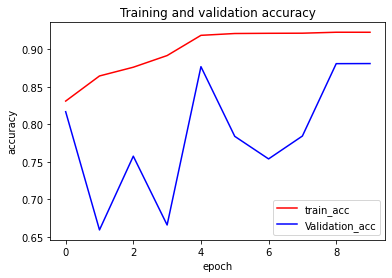

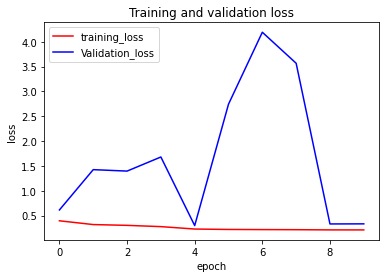

0.9225679039955139
0.8808091878890991


In [13]:
plot_acc_loss(CNN_LSTM_history)

2069/2069 [==============================] - 13s 6ms/step


<Figure size 432x288 with 0 Axes>

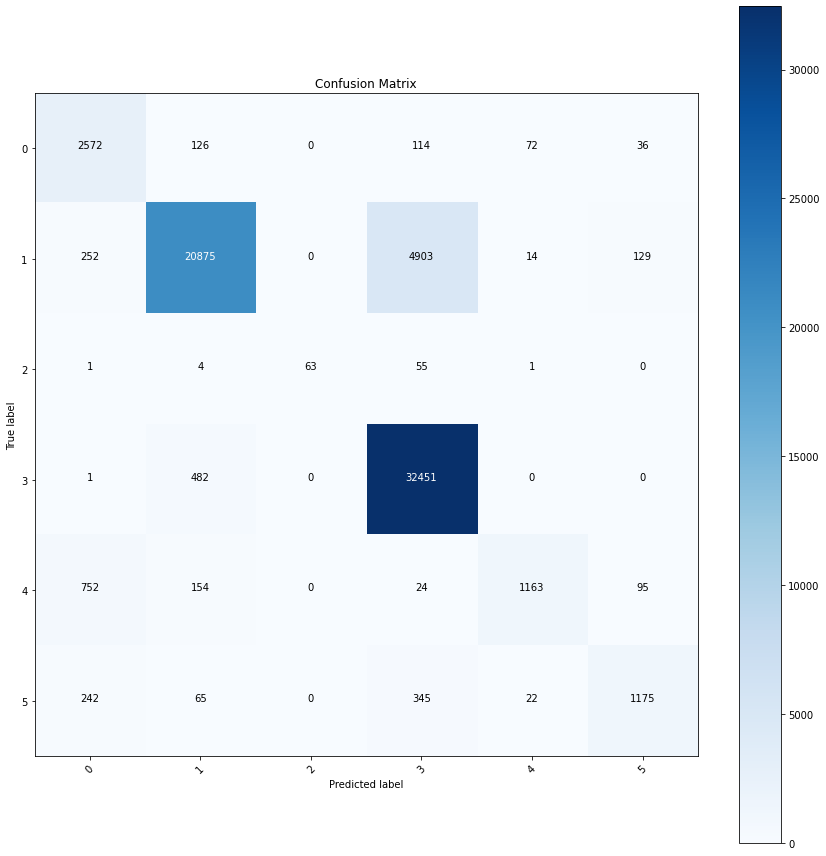

-----------------------------------------------------------------------------------------------------
Testing accuracy: 0.88081
-----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0    0.67330   0.88082   0.76320      2920
           1    0.96172   0.79758   0.87199     26173
           2    1.00000   0.50806   0.67380       124
           3    0.85641   0.98533   0.91636     32934
           4    0.91431   0.53154   0.67225      2188
           5    0.81882   0.63548   0.71559      1849

    accuracy                        0.88081     66188
   macro avg    0.87076   0.72314   0.76887     66188
weighted avg    0.89110   0.88081   0.87792     66188

-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
   Accuracy  Precision 

In [14]:
# # plot training accuracy and loss
# plot_acc_loss(CNN_LSTM_history)

y_pred, df_eva= models_evaluate(model_combine, class_num, X_test_CNN, X_train_CNN, X_test_LSTM,  X_train_LSTM, Y_test)

In [15]:
print('TNR', df_eva['TNR'].mean())
print('FPR', df_eva['FPR'].mean())
print('NPV', df_eva['NPV'].mean())


TNR 0.9650239236648877
FPR 0.034976076335112495
NPV 0.9718542321583264


In [ ]:
def replace_cat_prot(df):
    # replace numerical representation to text representation  -- category and protocol
    df['Cat'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    ['Normal', 'DDoS', 'PortScan', 'Okiru', 'Reconnaissance', 'Mirai', 'Sparta', 'MQQT_bruteforce', 
     'Torii', 'C&C', 'DoS', 'Attack', 'Flood', 'HeartBeat', 'MITM ARP Spoofing', 'FileDownload', 'Theft'], inplace=True)
    
    df['Protocol'].replace([0.0, 6.0, 17.0], ['HOPOPT', 'TCP', 'UDP'], inplace=True)
    
    return df
    

In [ ]:
def malicious_endpoint(predicted_labels, origin_testset):
    """
    Split malicious and normal endpoints by predicted labels
    Args:
        predicted_labels (_type_): predicted labels
        origin_testset (_type_): original testing dataset -- DataFrame
    Returns:
        Dataframe: splited malicious and normalinfo of endpoints
    """
    # replace numerical representation to text representation  -- category and protocol
    origin_testset = replace_cat_prot(origin_testset)
    
    # build a new dataset to display malicious and normal endpoints info in detailed
    df_malicious = pd.DataFrame(columns=['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol', 'Timestamp', 'Cat'])
    df_normal = pd.DataFrame(columns=['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol', 'Timestamp', 'Cat'])
    attack_index, normal_index = [], []  # store attack categories index in the dataframe
    
    # foreach to enumerate each index finding the predicted malicious and normal endpoints
    for i, k in enumerate(predicted_labels):
        if k != 0:
            attack_index.append({'Flow_ID': origin_testset.iloc[i][0], 'Src_IP': origin_testset.iloc[i][1], 
                        'Src_Port': origin_testset.iloc[i][2], 'Dst_IP': origin_testset.iloc[i][3], 
                        'Dst_Port': origin_testset.iloc[i][4], 'Protocol': origin_testset.iloc[i][5], 
                        'Timestamp': origin_testset.iloc[i][6], 'Cat': k})
        else:
            normal_index.append({'Flow_ID': origin_testset.iloc[i][0], 'Src_IP': origin_testset.iloc[i][1], 
                        'Src_Port': origin_testset.iloc[i][2], 'Dst_IP': origin_testset.iloc[i][3], 
                        'Dst_Port': origin_testset.iloc[i][4], 'Protocol': origin_testset.iloc[i][5], 
                        'Timestamp': origin_testset.iloc[i][6], 'Cat': 'Normal'})
    
    malicious_endpoint = df_malicious.append(attack_index)  # appending malicious list into dataframe
    normal_endpoint = df_normal.append(normal_index)  # appending normal list into dataframe
    
    malicious_endpoint = replace_cat_prot(malicious_endpoint)
    return malicious_endpoint, normal_endpoint
    

In [ ]:
malicious_endpoint, normal_endpoint = malicious_endpoint(y_pred, df_test_raw)

In [ ]:
normal_endpoint

In [ ]:
malicious_endpoint

In [ ]:
malicious_endpoint['Cat'].value_counts()

In [ ]:
normal_endpoint['Cat'].value_counts()

In [ ]:
# # plot receiver operating characteristic curve (ROC)
# print('-----------------------------------------------------------------------------------------------------')
# print('AUC: {:1.5f}' .format(auc_val))

# fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=15)  # roc curve
# plt.figure(figsize=(12, 12))  #s set plot size
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % auc_val)  # 假正率为横坐标，真正率为纵坐标做曲线
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()